In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.metrics as sklm
import sklearn.model_selection as ms
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from joblib import dump, load

In [2]:
def prepare_features(features,test,selected_cols,cat_cols):
    
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(features)
    
    features_fillna = pd.DataFrame(data=imputer.transform(features),
                               columns=features.columns,dtype='float')
    test_fillna = pd.DataFrame(data=imputer.transform(test),
                               columns=test.columns,dtype='float')

    test_row_ids = list(test['row_id']) 
    
    features_fillna.loc[:,cat_cols] = features_fillna[cat_cols].astype('int').astype('category')
    test_fillna.loc[:,cat_cols] = test_fillna[cat_cols].astype('int').astype('category')
    
    train_features = pd.get_dummies(features_fillna[selected_cols])
    test_features = pd.get_dummies(test_fillna[selected_cols])
    
    return train_features,test_features, test_row_ids 

In [3]:
def get_feature_importances(model,colnames,n):
    feature_importances = pd.DataFrame()
    feature_importances['features'] = colnames
    feature_importances['importance'] = model.feature_importances_ 
    feature_importances.sort_values(by='importance',ascending=False, inplace=True)
    feature_importances.reset_index(drop=True,inplace=True)
    feature_importances.set_index('features').iloc[0:n].plot(kind='bar',
                                                            figsize=(8,3))
    plt.xticks(rotation='vertical')
    return feature_importances.head(n)

In [4]:
def resample_data(features,labels,target,vals,new_fracs,seed=317):
    
    data = features.merge(labels,left_index=True,right_index=True)
    new_data = pd.DataFrame()
    L = len(data)
    
    for j in range(len(vals)):
        f = new_fracs[j]
        val = vals[j]
        n = int(round(L*f))
        sub_data = data[data[target]==val]
        sub_L = len(sub_data)
        
        if (n<=sub_L)and(n>0):
            temp = sub_data.sample(n=n,replace=False,
                           random_state=seed)
        if (n>sub_L):
            temp = sub_data.sample(n=n,replace=True,
                                   random_state=seed)
        if n<=0:
            temp = pd.DataFrame()

        if len(new_data)==0:
            new_data = temp
        else:
            new_data = pd.concat([new_data,temp])
        seed = seed+136
        
    new_features = new_data.drop(labels=target,axis=1).copy()
    new_labels = new_data[target].copy()
    return new_features,new_labels,new_data
        

In [5]:
def optimize_model(X,y,model_filename,already_optimized):
    
    if already_optimized:
        opt_XGBR = load(model_filename) 
    else:
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',max_depth=6,
                            learning_rate =0.1,n_estimators=100)
        #Optimizing max_depth and min_child_weight
        cv1 = ms.KFold(n_splits=4,shuffle = True,random_state=123)
        param_test1 = {'max_depth':range(2,25,2),
                       'min_child_weight':[1,10,50,100,500,1000,2000]}
        GS1 = ms.GridSearchCV(estimator = opt_XGBR, param_grid = param_test1, 
                          cv = cv1, # Use the inside folds
                          scoring = 'r2',
                          return_train_score = True,n_jobs=4)
        GS1.fit(X,y);
        print(GS1.best_params_)
        print('r^2 score =',GS1.best_score_)
        max_depth = GS1.best_params_['max_depth']
        min_child_weight = GS1.best_params_['min_child_weight']
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                            learning_rate =0.1,n_estimators=100)
        #Optimizing gamma
        cv2 = ms.KFold(n_splits=4,shuffle = True,random_state=342)
        param_test2 = {'gamma':[i/10.0 for i in range(0,5)]}
        GS2 = ms.GridSearchCV(estimator = opt_XGBR, param_grid = param_test2, 
                          cv = cv2, # Use the inside folds
                          scoring = 'r2',
                      return_train_score = True,n_jobs=4)
        GS2.fit(X,y);
        print(GS2.best_params_)
        print('r^2 score =',GS2.best_score_)
        gamma = GS2.best_params_['gamma']
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                gamma=gamma,
                            learning_rate =0.1,n_estimators=100)
        #Optimizing subsample and colsample_bytree
        cv3 = ms.KFold(n_splits=4,shuffle = True,random_state=71)
        param_test3 = {'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]}
        GS3 = ms.GridSearchCV(estimator = opt_XGBR, param_grid = param_test3, 
                          cv = cv3, # Use the inside folds
                          scoring = 'r2',
                          return_train_score = True,n_jobs=4)
        GS3.fit(X,y);
        print(GS3.best_params_)
        print('r^2 score =',GS3.best_score_)
        subsample = GS3.best_params_['subsample']
        colsample_bytree = GS3.best_params_['colsample_bytree']
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                gamma=gamma,
                                colsample_bytree=colsample_bytree,
                                subsample = subsample,
                            learning_rate =0.1,n_estimators=100)
        #Optimizing reg_alpha
        cv4 = ms.KFold(n_splits=4,shuffle = True,random_state=129)
        param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
        GS4 = ms.GridSearchCV(estimator = opt_XGBR, param_grid = param_test4, 
                          cv = cv4, # Use the inside folds
                          scoring = 'r2',
                          return_train_score = True,n_jobs=4)
        GS4.fit(X,y);
        print(GS4.best_params_)
        print('r^2 score =',GS4.best_score_)
        reg_alpha = GS4.best_params_['reg_alpha']
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                gamma=gamma,
                                colsample_bytree=colsample_bytree,
                                subsample = subsample,
                                reg_alpha = reg_alpha,
                            learning_rate =0.1,n_estimators=100)
        #Optimizing learning_rate
        cv5 = ms.KFold(n_splits=4,shuffle = True,random_state=976)
        param_test5 = {'learning_rate':[0.05,0.1,0.3,0.5,1]}
        GS5 = ms.GridSearchCV(estimator = opt_XGBR, param_grid = param_test5, 
                          cv = cv5, # Use the inside folds
                          scoring = 'r2',
                          return_train_score = True,n_jobs=4)
        GS5.fit(X,y);
        print(GS5.best_params_)
        print('r^2 score =',GS5.best_score_)
        learning_rate = GS5.best_params_['learning_rate']
        opt_XGBR = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=max_depth,
                                min_child_weight=min_child_weight,
                                gamma=gamma,
                                colsample_bytree=colsample_bytree,
                                subsample = subsample,
                                reg_alpha = reg_alpha,
                            learning_rate =learning_rate,
                                n_estimators=100,
                               n_jobs=4)
        dump(opt_XGBR, model_filename) 
    
    return opt_XGBR

In [6]:
location_cols = ['msa_md','state_code','county_code']
loan_info_cols = ['lender','loan_amount','loan_type',
                  'property_type','loan_purpose','occupancy',
                  'preapproval']
applicant_info_cols = ['applicant_income','applicant_ethnicity',
                      'applicant_race','applicant_sex','co_applicant']
census_info_cols = ['population','minority_population_pct',
                    'ffiecmedian_family_income',
                    'tract_to_msa_md_income_pct',
                    'number_of_owner-occupied_units',
                    'number_of_1_to_4_family_units']
all_cols = location_cols+loan_info_cols+applicant_info_cols+census_info_cols
#numeric columns (except censis info columns)
num_cols = ['loan_amount','applicant_income']
cat_cols = list(set(all_cols)-set(num_cols+census_info_cols))
target = 'rate_spread'

In [7]:
features = pd.read_csv('./Data/train_values.csv')
features.loc[features.applicant_sex>4,'applicant_sex'] = 4
labels = pd.read_csv('./Data/train_labels_abiUmgM.csv')
test = pd.read_csv('./Data/test_values.csv')
test.loc[test.applicant_sex>4,'applicant_sex'] = 4
data = features.merge(labels,on='row_id')

# Executive Summary
This report presents an analysis of the house mortgage data, which is publicly available data based on the Home Mortgage Disclosure Act (HMDA). 

A gradient boosting algorithm (from XGBoost package in python) was used to predict the mortgage rate from variables concerning property location, loan characteristics, applicant information and census information. The optimized model is able to explain %58 of the variance in the variance in the test set. As can be expected, the most important features turned out to the loan-related ones, such as property type, loan type, and loan purpose. 

The process of data exploration, feature selection and model fitting and optimization is described below in more details, followed by potential next steps to improve the model performance.

# Data Exploration and Feature selection
Home mortgage data contains four categories of features: 1) location, 2) loan information, 3) applicant information and 4) census information:

- location:
['msa_md', 'state_code', 'county_code']

#### loan information:
['lender', 'loan_amount', 'loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval']


#### applicant information:
['applicant_income', 'applicant_ethnicity', 'applicant_race', 'applicant_sex', 'co_applicant']

#### census information:
['population', 'minority_population_pct', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units']

Among these, 'loan_amount', 'applicant_income' and census information are numeric features and the rest are categorical features with no order.
The goal is to predict the mortgage rate, ’rate_spread’ using these 21 variables. Below I will investigate the correlations of each of these features with the target variable. I will go through each category separately. 

## Location 

In [8]:
location_agg_data = data[['msa_md', target]].groupby('msa_md').mean()
location_agg_data.reset_index(inplace=True)
location_agg_data.rename(columns={target:target+'_mean'},inplace=True)
#location_agg_data['location_group'] = pd.cut(location_agg_data.rate_spread_mean,
                                            #bins=[0,2.2,100],
                                            #labels=[1,2])
location_agg_data['location_group'] = location_agg_data[target+'_mean'].apply(round)

In [9]:
location_cols = ['msa_md','state_code','county_code']
location_cols.append('location_group')
all_cols = location_cols+loan_info_cols+applicant_info_cols+census_info_cols
#numeric columns (except censis info columns)
num_cols = ['loan_amount','applicant_income']
ordered_cat_cols = ['location_group']
cat_cols = list(set(all_cols)-set(num_cols+census_info_cols+ordered_cat_cols))

if ('location_group' not in features.columns):
    features = features.merge(location_agg_data[['msa_md','location_group']],
              how='outer',on='msa_md')
    data = data.merge(location_agg_data[['msa_md','location_group']],
          how='outer',on='msa_md')
    labels = data[target]
if ('location_group' not in test.columns):
    test = test.merge(location_agg_data[['msa_md','location_group']],
              how='left',on='msa_md')

The column ‘msa_md’ contains 409 distinct codes. In order to include these as a feature it is best to group them into larger categories. The left panel in the Figure below shows the average ’rate_spread’ grouped by ‘msa_md’. The distribution is clearly bimodal. Based on this I divide the ‘msa_md’ values in to two groups (dashed green line): the ones that have an average ’rate_spread’ below 2.2 ('location_group'=1), and the ones with an average above 2.2 ('location_group'=2), thereby I construct the new categorical feature 'location_group'. The box-plot on the left shows that this coarse-grained feature is able to separate the target variable effectively.

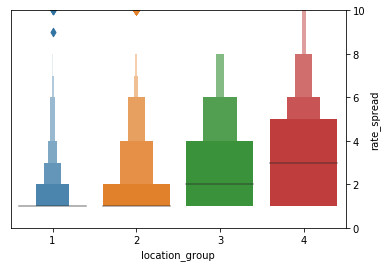

In [10]:
ax=sns.boxenplot(x='location_group',y=target,data=data)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.ylim([0,10]);

## Loan information
Among loan info. features, the 'lender' ids cannot be used in model training because the test data has lender ids that don’t appear in the train set. I therefore do not explore them here. Most of other categorical features in the loan info. group correlate with the target variable, and therefore all valuable features. As shown in Figure below, although 'preapproval' does not seem to have an effect on the target, it clearly matter whether 'loan_purpose'=2, 'loan_type'=1, 'property-type'=1 and 'occupancy'=3. This of course does not mean that all these features remain important when they are all included in the model, as the observed variance in some of these features might be explained by the other ones. As we will see, the gradient boosting model is able to select the most important features among these.    

In [11]:
lender_agg_data = data[['lender', target]].groupby('lender').mean()
lender_agg_data.reset_index(inplace=True)
lender_agg_data.rename(columns={target:target+'_mean'},inplace=True)
#lender_agg_data['lender_group'] = pd.cut(lender_agg_data.rate_spread_mean,
#                                            bins=[0,2,3,100],
#                                           labels=[1,2,3])
lender_agg_data['lender_group'] = lender_agg_data[target+'_mean'].apply(round)

In [12]:
loan_info_cols = ['lender','loan_amount','loan_type',
                  'property_type','loan_purpose','occupancy',
                  'preapproval']
loan_info_cols.append('lender_group')
all_cols = location_cols+loan_info_cols+applicant_info_cols+census_info_cols
#numeric columns (except censis info columns)
num_cols = ['loan_amount','applicant_income']
ordered_cat_cols.append('lender_group')
cat_cols = list(set(all_cols)-set(num_cols+census_info_cols+ordered_cat_cols))

if ('lender_group' not in features.columns):
    features = features.merge(lender_agg_data[['lender','lender_group']],
              how='outer',on='lender')
    data = data.merge(lender_agg_data[['lender','lender_group']],
          how='outer',on='lender')
    labels = data[target]
if ('lender_group' not in test.columns):
    test = test.merge(lender_agg_data[['lender','lender_group']],
              how='left',on='lender')

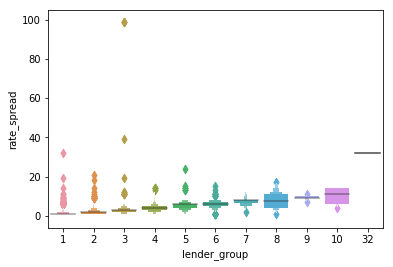

In [13]:
sns.boxenplot(x='lender_group',y=target,data=data)
#plt.ylim([0,20]);

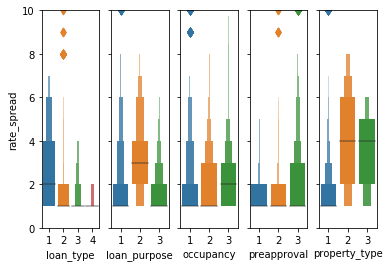

In [14]:
cols = list((set(loan_info_cols)-set(['lender','lender_group']))&set(cat_cols))
plt.figure()
pos = 1
for col in cols:
    if pos==1:
        plt.subplot(1,5,pos)
        ax=sns.boxenplot(x=col,y=target,data=data)
    else:
        plt.subplot(1,5,pos,sharey=ax)
        ax2=sns.boxenplot(x=col,y=target,data=data)
        plt.ylabel('')
        plt.setp(ax2.get_yticklabels(), visible=False)
        
    plt.ylim([0,10])
    pos = pos+1

As illustrated in the plot below, the numerical feature 'loan_amount' does not seem to correlate with the target. It seems that the highest values of 'loan_amount' correspond to lower values of ‘rate_spread’, but this might be coincidental; an artifact which arises due to the higher density of the data points with lower ‘rate_spread'.  

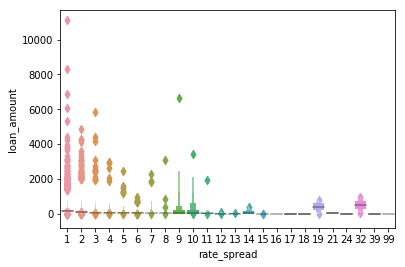

In [15]:
cols = list(set(loan_info_cols)&set(num_cols))
data[target] = data[target].astype(int)
for col in cols:
    plt.figure()
    sns.boxenplot(y=col,x=target,data=data)
    pos = pos+1
    #plt.ylim([0,10])

## Applicant information

In general, as illustrated below, the categorical features in applicant info group do not seem to correlate strongly with the target. It seems that it does not matter whether there is a 'co-applicant' or not. 
'applicant_race'=1, 'applicant_sex'=4 and 'applicant_ethnicity'=3 both seem to explain some variance in the target but, especially in the two latter cases, this might be coincidental as 'applicant_sex'=4 and 'applicant_ethnicity'=3 mean "not applicable" and "missing information" respectively.

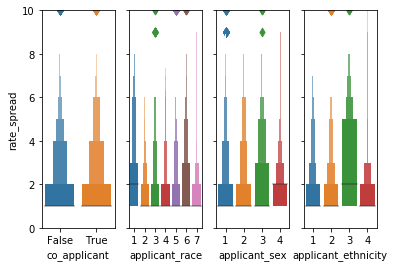

In [16]:
cols = list(set(applicant_info_cols)&set(cat_cols))

plt.figure()
pos = 1
for col in cols:
    if pos==1:
        plt.subplot(1,4,pos)
        ax=sns.boxenplot(x=col,y=target,data=data)
    else:
        plt.subplot(1,4,pos,sharey=ax)
        ax2=sns.boxenplot(x=col,y=target,data=data)
        plt.ylabel('')
        plt.setp(ax2.get_yticklabels(), visible=False)
        
    plt.ylim([0,10])
    pos = pos+1

The numerical feature, ‘applicant_income’, does not show a strong correlation with the target. The pattern is very similar to ‘loan_amount’. In fact, these two variables show a 0.45 correlation.

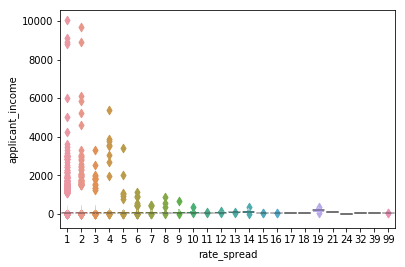

In [17]:
cols = list(set(applicant_info_cols)&set(num_cols))
for col in cols:
    plt.figure()
    sns.boxenplot(x=target,y=col,data=data)
    #plt.ylim([0,10])

In [18]:
coef = data[['applicant_income','loan_amount']].corr().iloc[0][1]

# sns.jointplot(x='applicant_income',y='loan_amount',
#               data=data,kind='reg',height=4)
# plt.xlim([0,2000])
# plt.ylim([0,2000]);
# #plt.title('correlation ='+str(round(coef,2)));

In [19]:
#fig = plt.gcf(3)
#fig.get_size_inches() # size in pixels

Although I will include the applicant information in the model, I expect that applicant information turn out to be less important than the loan information.

## Census information

Census information do not have any direct information related to loan. It might indirectly reflect the location, but I have already included the location information in the model. Based on this, I will not include these features in the model.

In [20]:
#col = [0]
#for col in census_info_cols:
    #bins = np.arange(0.8,4,0.2)
    #plt.figure()
    #sns.distplot(data.groupby(col)[target].mean(),bins=bins);
    #plt.title('Grouped by '+col)
    #plt.xlabel('average  '+target)
    #plt.ylabel('Normalized distribution');

## Target variable
One important point about the target variable is that it is an integer; it only takes discrete values. The distribution of the target variable is illustrated below together with the summary statistics:

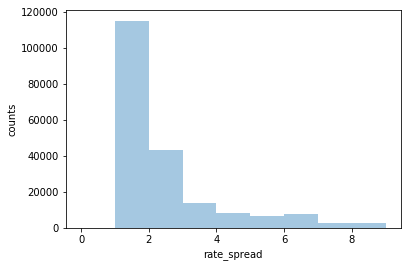

In [21]:
sns.distplot(labels,bins=range(10),norm_hist=False,kde=False)
plt.ylabel('counts');

In [22]:
data[target].describe()

count    200000.000000
mean          1.979110
std           1.656809
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          99.000000
Name: rate_spread, dtype: float64

In [23]:
#labels.value_counts().sort_index()

It is clear that most of the data points have the target value of ‘rate_spread’=1. This have a potential to bias the model towards lower values of the target. To check this, I considered a ‘constant model’, which predicts ‘rate_spread’=1 for every data point. Predicting on the test data set led to an r-squared score of -0.33. This means that the data points with ‘rate_spread’=1 do not completely dominate the variance of the target values. Still, it is possible that the model turns out to be more accurate in predicting lower values of ‘rate_spread’. This issue can be resolved by balancing the data through resampling. Nonetheless in this report I will not go through the resampling the data, with the goal of training a base model on the original data and assessing the effect of the bias.

# Feature preparation
I included in the model the applicant information and loan information features (except the ‘lender’ feature), plus the newly constructed ‘location group’ features. For the ‘applicant-income’ feature, the NaN values were imputed with the most probable value, and an new Boolean feature was created to indicate whether ‘applicant-income’ was undetermined or not. All other features are categorical, and were transformed using one-hot encoding. This produced a feature matrix with 38 columns.

In [24]:
test.sort_values(by='row_id',inplace=True)
selected_cols = list(set(loan_info_cols)-set(['lender']))+['location_group']+applicant_info_cols+census_info_cols

train_features, test_features, test_row_ids = prepare_features(features,test,
                                                 selected_cols,cat_cols)

In [25]:
# vals = np.sort(labels.unique())
# new_fracs = np.zeros(len(vals))
# new_fracs[0:8] = 1.0
# new_fracs = new_fracs/np.sum(new_fracs)
# new_train_features,new_labels,_ = resample_data(train_features,labels,target,vals,new_fracs,seed=317)

In [26]:
print(train_features.shape)
train_features.head()

(200000, 43)


,lender_group,loan_amount,location_group,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,...,applicant_race_4,applicant_race_5,applicant_race_6,applicant_race_7,applicant_sex_1,applicant_sex_2,applicant_sex_3,applicant_sex_4,co_applicant_0,co_applicant_1
0,1.0,139.0,2.0,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0,...,0,1,0,0,1,0,0,0,0,1
1,1.0,129.0,2.0,99.0,4656.0,1.943,60677.0,100.000,1684.0,2053.0,...,0,1,0,0,1,0,0,0,0,1
2,1.0,97.0,2.0,45.0,5135.0,12.460,61258.0,100.000,1372.0,3083.0,...,0,1,0,0,1,0,0,0,0,1
3,1.0,32.0,2.0,43.0,1828.0,2.122,59805.0,77.174,719.0,904.0,...,0,1,0,0,1,0,0,0,1,0
4,1.0,88.0,2.0,50.0,3433.0,5.161,59167.0,100.000,1167.0,1559.0,...,0,1,0,0,0,1,0,0,0,1


In [27]:
print(test_features.shape)
test_features.head()

(200000, 43)


,lender_group,loan_amount,location_group,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,...,applicant_race_4,applicant_race_5,applicant_race_6,applicant_race_7,applicant_sex_1,applicant_sex_2,applicant_sex_3,applicant_sex_4,co_applicant_0,co_applicant_1
0,6.0,46.0,2.0,50.0,10761.0,43.415,61732.0,100.000,2900.0,3603.0,...,0,1,0,0,0,1,0,0,1,0
1,3.0,170.0,2.0,155.0,2285.0,20.115,50373.0,100.000,539.0,873.0,...,0,1,0,0,1,0,0,0,1,0
2,2.0,174.0,2.0,102.0,7765.0,78.621,75175.0,54.165,1559.0,1712.0,...,0,1,0,0,1,0,0,0,1,0
3,2.0,116.0,2.0,51.0,3387.0,96.208,48677.0,74.476,938.0,784.0,...,0,1,0,0,1,0,0,0,0,1
4,2.0,108.0,2.0,88.0,3106.0,6.370,68070.0,100.000,1119.0,1301.0,...,0,1,0,0,1,0,0,0,1,0


In [28]:
X = train_features.to_numpy()
y = np.ravel(labels.to_numpy())
X_test = test_features.to_numpy()

# Training and optimization a gradient boosting regressor
Initially I tried an Adaboost regressor, which resulted in a low predictive power (r-squared ~ 0.39). Using a gradient boosting regressor from XGboost package resulted in a significantly improved performance. Using the default setting with booster='gbtree' and objective= 'reg:squarederror' yielded an r-squared of about 0.54. I therefore decided to continue with the gradient boosting method.

The ‘GradientBoostingRegressor’ has multiple tunable parameters (see https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/). 
These include

-	max_depth [default: 3]: The maximum depth of a tree.
-	learning_rate [default: 0.1]: The learning rate.
-	n_estimators [default: 100]: The number of boosting stages to perform.
-	gamma [default: 0]: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
-	min_child_weight [default: 1]: Defines the minimum sum of weights of all observations required in a child.
-	max_delta_step [default: 0]: In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
-	Subsample [default: 1]: Denotes the fraction of observations to be randomly samples for each tree.
-	colsample_bytree [default: 1]: Denotes the fraction of columns to be randomly sampled for each tree.
-	colsample_bylevel [default: 1]: Denotes the subsample ratio of columns for each split, in each level.
-	colsample_bynode [default: 1]: Denotes the subsample ratio of columns for each split.
-	reg_alpha [default: 0]: L1 regularization term on weight (analogous to Lasso regression).
-	reg_lambda [default: 1]: L2 regularization term on weights (analogous to Ridge regression).
-	scale_pos_weight [default: 1]: A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 


In [29]:
already_optimized = True
model_filename = 'opt_Xgboost_reg_final.joblib'

opt_XGBR = optimize_model(X,y,model_filename,already_optimized)

{'max_depth': 12, 'min_child_weight': 100}
r^2 score = 0.7390054726768674
{'gamma': 0.4}
r^2 score = 0.7396873872120951
{'colsample_bytree': 0.9, 'subsample': 0.9}
r^2 score = 0.7386285352222725
{'reg_alpha': 0.1}
r^2 score = 0.7383175085787065
{'learning_rate': 0.05}
r^2 score = 0.7385507809817221


Using the grid-search cross-validation (‘GridSearchCV’in sklearn), I optimized seven of these parameters in five steps in the following order: 1) ‘max_depth’ together with ‘min_child_weight’, 2) ‘gamma’, 3) ‘subsample’ together with  ‘colsample_bytree’, 4) 'reg_alpha' and 5) ‘learning_rate’. This resulted in the following optimal parameters: ‘max_depth’=8, ‘min_child_weight’=50, ‘gamma’=0.3, ‘subsample’=0.9, ‘colsample_bytree’=0.7, ‘reg_alpha’=1e-05 and ‘learning_rate’=0.1. 

# Validating the model
To validate the model, I followed the usual practice of splitting the data into a training set and a validation set (with ‘test_size=0.33’ in the ‘train_test_split’ method in sklearn). Traning the model retuned the following feature importance: 

#### Cross validation

In [54]:
cv = ms.KFold(n_splits=4,shuffle = True,random_state=546)
scores = ms.cross_val_score(opt_XGBR,X,y,cv=cv,scoring='r2')
print(np.mean(scores))
print(np.std(scores))

0.7388362763283842
0.019219752018817378


In [49]:
 X_train, X_val, y_train, y_val = ms.train_test_split(
...     X, y, test_size=0.33, random_state=75)

In [50]:
opt_XGBR.fit(X_train,y_train);

As expected, the top five most important features are all in the loan information group ( ‘property_type_1’, ‘property_type_2’, ‘loan_type_2’, ‘loan_type_1’ and ‘loan_purpose_2’, respectively). Applicant-related features (such as ‘applicant_ethnicity_4’) appear with a much lower rank (more than 20 times smaller compared to the most important feature). Surprisingly, the constructed feature 'location_group' turned out to be unimportant. This means that the observed difference in 'location_group' can be captured by other features.  

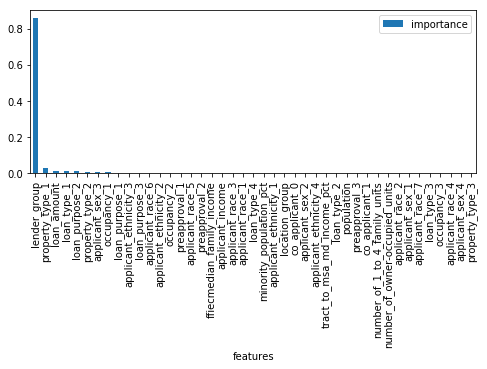

In [51]:
importances = get_feature_importances(opt_XGBR,
                       colnames=train_features.columns,
                            n=len(train_features.columns))

In [52]:
importances.head(10)

,features,importance
0,lender_group,0.859831
1,property_type_1,0.029540
2,loan_amount,0.013736
3,loan_type_1,0.011651
4,loan_purpose_2,0.010597
5,property_type_2,0.006675
6,applicant_sex_3,0.006098
7,occupancy_1,0.003807
8,loan_purpose_1,0.003559
9,applicant_ethnicity_3,0.003449


In [53]:
sklm.r2_score(y_val,opt_XGBR.predict(X_val))

0.7382927201374554

In [36]:
validation = pd.DataFrame()
validation['data']=y_val
validation['data'] = validation['data'].astype(int)
validation['prediction']=opt_XGBR.predict(X_val)

Prediction on the validation set yielded an r-squared of 0.57, quite similar to the obtained test score of 0.58. This indicates that the model generalizes well. The Figure below compares the actual vs. predicted target values for the validation set (only the data points with ‘rate_spread’ smaller than 15 are shown). In general, the model has a decent performance. However, it is clear that the model performs better for ‘rate_spread’=1,2 compared to larger target values where the predictions underestimate the actual values. This implies that the large number of low target values has indeed partially biased the model. 

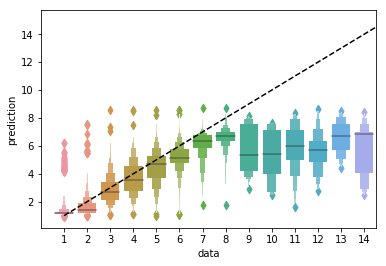

In [37]:
sns.boxenplot(x='data',y='prediction',data=validation)
plt.plot([0,14],[1,15],'k--');
plt.xlim([-1,13.5]);

In [38]:
opt_XGBR.fit(X,y)
y_pred = opt_XGBR.predict(X_test)

In [39]:
predictions = pd.DataFrame()
predictions['row_id'] = test.row_id
predictions[target] = y_pred
#predictions.head()

# Conclusion
This report describes the procedure I followed to predict the mortgage rate from location-related, loan-related and applicant-related variables. A gradient boosting algorithm was shown to be able to capture nearly 60 percent of the variance in the test data set, identifying the loan-related features as the dominant predictors.

The next step to improve the model predictive power is to resample the training data to eliminate the imbalance in the distribution of the target variables.

In [41]:
# Appendix: Initial trainings

In [42]:
#Testing other models (AdaBoost)
adaboost_model = AdaBoostRegressor()
adaboost_model.fit(X_train,y_train)
adaboost_r2 = sklm.r2_score(y_val,adaboost_model.predict(X_val))

In [43]:
# Default xgboost
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')
xgboost_model.fit(X_train,y_train)
xgboost_r2 = sklm.r2_score(y_val,xgboost_model.predict(X_val))